In [ ]:
#libs needed for homework
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [ ]:
#to mount drive and use other csv files provided
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
#to use GPU for faste runtime
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Not connected to a GPU
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
#load csv files into dataframes
rain = pd.read_csv("drive/MyDrive/gro_homework/Precipitation.csv")
predf = pd.read_csv("drive/MyDrive/gro_homework/Prediction.csv")
temp = pd.read_csv("drive/MyDrive/gro_homework/Temperature.csv")
ndvi = pd.read_csv("drive/MyDrive/gro_homework/NDVI.csv")
moist = pd.read_csv("drive/MyDrive/gro_homework/Moisture.csv")
produced = pd.read_csv("drive/MyDrive/gro_homework/Production.csv")

In [ ]:
#get broad level view of data; produced is monthly whereas other csv files with features are given daily. For LSTM, it is probably best to average daily features to monthly
print(produced[:5])
rain[:5]

                 start_date                  end_date    prod  region_id
0  2015-01-01T00:00:00.000Z  2015-01-31T00:00:00.000Z  171725         93
1  2015-02-01T00:00:00.000Z  2015-02-28T00:00:00.000Z  188325         93
2  2015-03-01T00:00:00.000Z  2015-03-31T00:00:00.000Z  247856         93
3  2015-04-01T00:00:00.000Z  2015-04-30T00:00:00.000Z  282791         93
4  2015-05-01T00:00:00.000Z  2015-05-31T00:00:00.000Z  291057         93


,start_date,end_date,precip,region_id
0,2014-01-01T00:00:00.000Z,2014-01-01T00:00:00.000Z,1.392393,93
1,2014-01-02T00:00:00.000Z,2014-01-02T00:00:00.000Z,0.315380,93
2,2014-01-03T00:00:00.000Z,2014-01-03T00:00:00.000Z,2.347846,93
3,2014-01-04T00:00:00.000Z,2014-01-04T00:00:00.000Z,21.466357,93
4,2014-01-05T00:00:00.000Z,2014-01-05T00:00:00.000Z,32.823651,93


In [ ]:
#Now proceeding to cleaning data and organizing it so that it can be used in NN.
#There are no rows with missing values, but there is missing data for day-to-day basis, which
#further hints that it might be best to average daily values to monthly values
data = [rain,temp,ndvi,moist]
for e in data:
  print(e.shape)
  e.dropna()
  print(e.shape)

(29940, 4)
(29940, 4)
(12930, 4)
(12930, 4)
(3338, 4)
(3338, 4)
(29603, 4)
(29603, 4)


In [ ]:
#only concerned with feature data from 2015 to 2021 , so drop rest
for e in list(data):
  indices = e.index[e["start_date"].str.contains("2013|2014|2022")].tolist()
  e = e.drop(indices)
  data.append(e)
  print(e.shape)

data = data[4:8]
data[0]

(25570, 4)
(10781, 4)
(2835, 4)
(25326, 4)


,start_date,end_date,precip,region_id
365,2015-01-01T00:00:00.000Z,2015-01-01T00:00:00.000Z,2.278169,93
366,2015-01-02T00:00:00.000Z,2015-01-02T00:00:00.000Z,0.863206,93
367,2015-01-03T00:00:00.000Z,2015-01-03T00:00:00.000Z,0.312079,93
368,2015-01-04T00:00:00.000Z,2015-01-04T00:00:00.000Z,0.411836,93
369,2015-01-05T00:00:00.000Z,2015-01-05T00:00:00.000Z,2.275593,93
...,...,...,...,...
29863,2021-12-27T00:00:00.000Z,2021-12-27T00:00:00.000Z,0.000310,105
29864,2021-12-28T00:00:00.000Z,2021-12-28T00:00:00.000Z,0.036990,105
29865,2021-12-29T00:00:00.000Z,2021-12-29T00:00:00.000Z,6.672680,105
29866,2021-12-30T00:00:00.000Z,2021-12-30T00:00:00.000Z,68.320669,105


In [ ]:
#function to create array with average monthly values for precipitation for a given date
#and region. If data is missing for a month, returns zero (should not pose problem for NN)
rain_data = []
r = data[0]
r = r.reset_index(drop=True)

zeros = 0
for region in [93,94,95,97,98,99,102,103,104,105]:
  for year in range(2015,2022):
    for month in range(1,13):
      if month < 10:
        date = str(year) + '-0' + str(month)
      else:
        date = str(year) + '-' + str(month)
      indices = r.index[(r["start_date"].str.contains(date)) & (r["region_id"] == region)].tolist()
      if len(indices) == 0:
        avg = 0
        zeros += 1
        print(year,month,region)
      else:
        count = 0
        sum = 0
        for i in indices:
          count += 1
          sum += r.iloc[i][2]
        avg = sum/count
      rain_data.append([year,month,avg,region])
  print(region)
print("Number of months missing: " + str(zeros))

93
94
95
97
98
99
102
103
104
105
Number of months missing: 0


In [ ]:
temp_data = []
t = data[1]
t = t.reset_index(drop=True)

zeros = 0
for region in [93,94,95,97,98,99,102,103,104,105]:
  for year in range(2015,2022):
    for month in range(1,13):
      if month < 10:
        date = str(year) + '-0' + str(month)
      else:
        date = str(year) + '-' + str(month)
      indices = t.index[(t["start_date"].str.contains(date)) & (t["region_id"] == region)].tolist()
      if len(indices) == 0:
        avg = 0
        zeros += 1
        print(year,month,region)
      else:
        count = 0
        sum = 0
        for i in indices:
          count += 1
          sum += t.iloc[i][2]
        avg = sum/count
      temp_data.append([year,month,avg,region])
  print(region)
print("Number of months missing: " + str(zeros))

93
94
95
97
98
99
102
103
104
105
Number of months missing: 0


In [ ]:
ndvi_data = []
n = data[2]
n = n.reset_index(drop=True)

zeros = 0
for region in [93,94,95,97,98,99,102,103,104,105]:
  for year in range(2015,2022):
    for month in range(1,13):
      if month < 10:
        date = str(year) + '-0' + str(month)
      else:
        date = str(year) + '-' + str(month)
      indices = n.index[(n["start_date"].str.contains(date)) & (n["region_id"] == region)].tolist()
      if len(indices) == 0:
        avg = 0
        zeros += 1
        print(year,month,region)
      else:
        count = 0
        sum = 0
        for i in indices:
          count += 1
          sum += n.iloc[i][2]
        avg = sum/count
      ndvi_data.append([year,month,avg,region])
  print(region)
print("Number of months missing: " + str(zeros))

93
94
95
2016 11 97
97
98
99
102
103
2016 11 104
104
2016 11 105
2018 1 105
105
Number of months missing: 4


In [ ]:
moist_data = []
m = data[3]
m = m.reset_index(drop=True)

zeros = 0
for region in [93,94,95,97,98,99,102,103,104,105]:
  for year in range(2015,2022):
    for month in range(1,13):
      if month < 10:
        date = str(year) + '-0' + str(month)
      else:
        date = str(year) + '-' + str(month)
      indices = m.index[(m["start_date"].str.contains(date)) & (m["region_id"] == region)].tolist()
      if len(indices) == 0:
        avg = 0
        zeros += 1
        print(year,month,region)
      else:
        count = 0
        sum = 0
        for i in indices:
          count += 1
          sum += m.iloc[i][2]
        avg = sum/count
      moist_data.append([year,month,avg,region])
  print(region)
print("Number of months missing: " + str(zeros))

93
94
95
97
98
99
102
103
104
105
Number of months missing: 0


In [ ]:
rain_data

[[2015, 1, 4.3944521692979155, 93],
 [2015, 2, 1.2061374877264543, 93],
 [2015, 3, 3.454652321991812, 93],
 [2015, 4, 10.466471728220673, 93],
 [2015, 5, 9.00798604652708, 93],
 [2015, 6, 4.8583554313766815, 93],
 [2015, 7, 5.410754769006925, 93],
 [2015, 8, 5.8257606115086285, 93],
 [2015, 9, 4.057923635098385, 93],
 [2015, 10, 5.668796881143408, 93],
 [2015, 11, 12.967481653924702, 93],
 [2015, 12, 7.258166540396948, 93],
 [2016, 1, 3.542147438725205, 93],
 [2016, 2, 5.58337240264083, 93],
 [2016, 3, 2.8098904441569528, 93],
 [2016, 4, 5.533220066194149, 93],
 [2016, 5, 7.210376466997511, 93],
 [2016, 6, 4.483826140163365, 93],
 [2016, 7, 4.3716072833100315, 93],
 [2016, 8, 2.6814583387069275, 93],
 [2016, 9, 6.487781566135967, 93],
 [2016, 10, 8.089447971540029, 93],
 [2016, 11, 8.922519544656952, 93],
 [2016, 12, 6.877924901866296, 93],
 [2017, 1, 10.953848213162976, 93],
 [2017, 2, 4.460164492852441, 93],
 [2017, 3, 8.751595205398333, 93],
 [2017, 4, 13.194064977605025, 93],
 [201

In [ ]:
#turn lists to numpy arrays
rain_data = np.array(rain_data)
temp_data = np.array(temp_data)
ndvi_data = np.array(ndvi_data)
moist_data = np.array(moist_data)

In [ ]:
#prepare y data for NN
produced = produced["prod"].values
produced = produced.astype(np.float64)
produced = np.reshape(produced,(720,1))

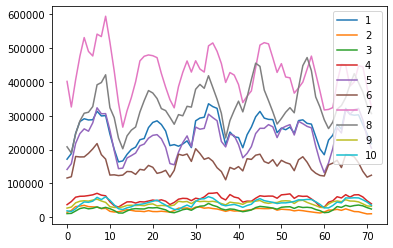

In [ ]:
#plot region data to see if there is yearly trends that can be taken advantage of when
#creating NN model. In this case, cyclical data means singular model can probably be trained for all
#regions, as individual models for each region would run into problem of only having 72 samples
gra = produced
for i in range(1,11):
    line, = plt.plot(range(72),gra[72*(i-1):72*i])
    line.set_label(str(i))
plt.legend()
plt.show()

In [ ]:
#create features with months and 4 csv characteristics
features = np.column_stack((rain_data[:,1:3],temp_data[:,2],ndvi_data[:,2],moist_data[:,2]))
print(features.shape)
produced.shape

(840, 5)


(720, 1)

In [ ]:
#implement regions as a feature based on graph above by assigning regions with similar y-value similar values
regions = np.repeat([0.6,0.1,0.15,0.2,0.58,0.4,1.0,0.8,0.16,0.18],84)
regions = np.reshape(regions,(840,1))
regions.shape

(840, 1)

In [ ]:
#produced values also features in LSTM model
features = np.column_stack((features,regions))
print(features.shape)

#scale data using min-max
scaler = MinMaxScaler()
scaler = scaler.fit(features)
scaled_features = scaler.transform(features)

predictors = scaled_features[-120:]
scaled_features = scaled_features[:720]

#scale produced values
scaler = scaler.fit(produced)
scaled_produced = scaler.transform(produced)

scaled_features = np.column_stack((scaled_produced,scaled_features))

(840, 6)


In [ ]:
scaled_features.shape

(720, 7)

In [ ]:
trainX = []
trainY = []
n_future = 1
window = 4

for j in range(1,11):
  temp = scaled_features[72*(j-1):72*j]
  for i in range(window,len(temp) - n_future + 1):
    trainX.append(temp[i - window:i,0:scaled_features.shape[1]])
    trainY.append(temp[i + n_future - 1: i + + n_future, 0])


In [ ]:
print(trainX[0],trainY[0])

[[0.27685973 0.         0.20065423 0.24284853 0.89577537 0.64304896
  0.55555556]
 [0.30531538 0.09090909 0.049027   0.43670237 0.89310307 0.57275159
  0.55555556]
 [0.40736316 0.18181818 0.15596001 0.45244949 0.88580363 0.47033234
  0.55555556]
 [0.46724858 0.27272727 0.48942231 0.45188599 0.92381549 0.4624113
  0.55555556]] [0.48141812]


In [ ]:
trainX = np.array(trainX)
trainY = np.array(trainY)

print('TrainX shape == ' + str(trainX.shape))
print('TrainY shappe == ' + str(trainY.shape))

TrainX shape == (680, 4, 7)
TrainY shappe == (680, 1)


In [ ]:
inp = Input(shape=(4, 7))
x = LSTM(64, activation='relu', input_shape=(4, 7), return_sequences=True)(inp)
x = LSTM(32, activation='relu', return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(trainY.shape[1],activation="sigmoid")(x)
model = tf.keras.models.Model(inp, x)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4, 7)]            0         
                                                                 
 lstm_18 (LSTM)              (None, 4, 64)             18432     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
306/306 [==============================] - 3s 6ms/step - loss: 0.0329 - val_loss: 0.0013
Epoch 2/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0065 - val_loss: 0.0013
Epoch 3/50
306/306 [==============================] - 2s 6ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 4/50
306/306 [==============================] - 2s 7ms/step - loss: 0.0046 - val_loss: 0.0010
Epoch 5/50
306/306 [==============================] - 3s 9ms/step - loss: 0.0041 - val_loss: 6.1751e-04
Epoch 6/50
306/306 [==============================] - 3s 9ms/step - loss: 0.0041 - val_loss: 6.2860e-04
Epoch 7/50
306/306 [==============================] - 2s 8ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 8/50
306/306 [==============================] - 1s 5ms/step - loss: 0.0035 - val_loss: 3.3420e-04
Epoch 9/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0034 - val_loss: 3.8589e-04
Epoch 10/50
306/306 [==============================] - 1s 4ms/step - loss: 0.0033 - 

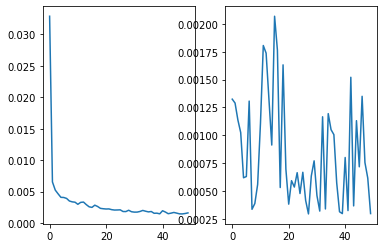

In [ ]:
history = model.fit(trainX, trainY, epochs=50, batch_size=2, validation_split=0.1, verbose=1)
fig, ax = plt.subplots(ncols = 2)
ax[0].plot(history.history['loss'], label='Training loss')
ax[1].plot(history.history['val_loss'], label='Validation loss')


In [ ]:
pred_arr = []
for j in range(1,11):
  input = trainX[68*j-1].reshape(1,4,7)
  print(input.shape)
  prediction = model.predict(input)
  pred_arr.append(prediction)

  for i in range(11):
    new_features = predictors[i+11*(j-1)].reshape((6,1))
    new = np.append(prediction,new_features).reshape(1,1,7)
#new = new.reshape(1,1,7)
    input = np.column_stack((input[:,:3,:],new))
    prediction = model.predict(input)
    pred_arr.append(prediction)


(1, 4, 7)
(1, 4, 7)
(1, 4, 7)
(1, 4, 7)
(1, 4, 7)
(1, 4, 7)
(1, 4, 7)
(1, 4, 7)
(1, 4, 7)
(1, 4, 7)


In [ ]:
len(pred_arr)
pred_arr[0] = pred_arr[0].reshape((-1,1))
type(pred_arr[0])
y_pred_future = scaler.inverse_transform(pred_arr[0])

In [ ]:
y_pred_future

array([[234423.95]], dtype=float32)

In [ ]:
scaled_pred = []
for pred in pred_arr:
  temp = pred.reshape((-1,1))
  scaled_pred.append(scaler.inverse_transform(temp))



In [ ]:
scaled_pred

[array([[234423.95]], dtype=float32),
 array([[277785.53]], dtype=float32),
 array([[294778.56]], dtype=float32),
 array([[298886.7]], dtype=float32),
 array([[298485.94]], dtype=float32),
 array([[299653.78]], dtype=float32),
 array([[301126.66]], dtype=float32),
 array([[303680.4]], dtype=float32),
 array([[303192.22]], dtype=float32),
 array([[300770.62]], dtype=float32),
 array([[285543.47]], dtype=float32),
 array([[284261.97]], dtype=float32),
 array([[15103.622]], dtype=float32),
 array([[15505.004]], dtype=float32),
 array([[19690.258]], dtype=float32),
 array([[19729.184]], dtype=float32),
 array([[18990.469]], dtype=float32),
 array([[17317.436]], dtype=float32),
 array([[17317.488]], dtype=float32),
 array([[17330.996]], dtype=float32),
 array([[16746.736]], dtype=float32),
 array([[16884.36]], dtype=float32),
 array([[16432.178]], dtype=float32),
 array([[16175.079]], dtype=float32),
 array([[26944.416]], dtype=float32),
 array([[26125.363]], dtype=float32),
 array([[25584.

In [ ]:
predf["prod"] = scaled_pred

In [ ]:
predf

,start_date,end_date,prod,region_id
0,2021-01-01T00:00:00.000Z,2021-01-31T00:00:00.000Z,[[234423.95]],93
1,2021-02-01T00:00:00.000Z,2021-02-28T00:00:00.000Z,[[277785.53]],93
2,2021-03-01T00:00:00.000Z,2021-03-31T00:00:00.000Z,[[294778.56]],93
3,2021-04-01T00:00:00.000Z,2021-04-30T00:00:00.000Z,[[298886.7]],93
4,2021-05-01T00:00:00.000Z,2021-05-31T00:00:00.000Z,[[298485.94]],93
...,...,...,...,...
115,2021-08-01T00:00:00.000Z,2021-08-31T00:00:00.000Z,[[29200.998]],105
116,2021-09-01T00:00:00.000Z,2021-09-30T00:00:00.000Z,[[28005.965]],105
117,2021-10-01T00:00:00.000Z,2021-10-31T00:00:00.000Z,[[27355.135]],105
118,2021-11-01T00:00:00.000Z,2021-11-30T00:00:00.000Z,[[36113.547]],105


In [ ]:
from google.colab import files

predf.to_csv('sbeurnier10@berkeley.edu.csv', encoding = 'utf-8-sig') 
files.download('sbeurnier10@berkeley.edu.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>